# REVEA

REVEA (Reference Vector Guided Evolutionary Algorithm) is a many-objective evolutionary algorithm designed to efficiently approximate the Pareto front by dynamically adapting a set of reference vectors. By guiding the search with these vectors, REVEA maintains a balance between convergence toward optimality and diversity across the objective space.

## Key Features

- **Dynamic Reference Vectors:**  
  REVEA starts with an initial set of reference vectors and periodically updates them using the current population’s extreme objective values (the ideal and nadir points). This update mechanism ensures that the reference vectors remain aligned with the evolving search space.

- **Angle Penalized Distance (APD):**  
  A core component of REVEA is the Angle Penalized Distance metric, which combines the angular deviation (denoted by $\theta$, the angle between a solution and its associated reference vector) with a scaling factor that adapts over generations. In essence, APD favors solutions that are both close in direction to the reference vector and robust in magnitude.

- **Reference Vector Association:**  
  Each solution is associated with the reference vector with which it has the highest cosine similarity. This association partitions the population into niches, promoting a uniform spread of solutions along the Pareto front.

- **Adaptive Selection:**  
  In the survival selection phase, REVEA selects, from each niche, the solution with the smallest APD. This elitist approach helps ensure that all regions of the objective space are well represented in the next generation.

## Reference Vector Association and APD

### Association Mechanism

Let ${\mathbf{v}_1^t, \mathbf{v}_2^t, \dots, \mathbf{v}_N^t}$ be the reference vector set at generation $t$. For each solution $\mathbf{f}(\mathbf{x})$, the cosine similarity with each reference vector is computed. The solution is then assigned to the reference vector for which the angular difference (i.e. the angle $\theta$ between them) is minimized.

### Angle Penalized Distance (APD)

For a solution $\mathbf{f}_i$ associated with reference vector $\mathbf{v}_j^t$, the Angle Penalized Distance is given by:

$$
\text{APD}_{ij} = \Bigl( 1 + M \Bigl(\frac{t}{t_{\max}}\Bigr)^\alpha \cdot \frac{\theta_{ij}}{\gamma_j} \Bigr) \cdot \|\mathbf{f}_i\|
$$

where:
- $M$ is the number of objectives,
- $t$ is the current generation and $t_{\max}$ is the maximum number of generations,
- $\alpha$ is a control parameter,
- $\gamma_j$ is a scaling factor for the $j$-th reference vector (often computed as the minimum inner product between $\mathbf{v}_j^t$ and the other reference vectors),
- $\theta_{ij}$ is the angle between the solution $\mathbf{f}_i$ and the reference vector $\mathbf{v}_j^t$, and
- $\|\mathbf{f}_i\|$ is the norm of the (possibly translated) objective vector of the solution.

**Brief Interpretation of APD:**  
The APD metric measures how well a solution aligns with its associated reference vector. A lower APD indicates that the solution is not only close in angle (small $\theta_{ij}$) to the reference direction, reflecting good convergence, but also has a desirable magnitude. The term $M\Bigl(\frac{t}{t_{\max}}\Bigr)^\alpha$ gradually increases the penalty on angular deviation over generations, thus promoting diversity in the early stages and fine convergence later on.

### Reference Vector Update

At a predefined frequency $fr$, the reference vectors are updated to better reflect the current objective landscape. Given the ideal point $z_{\min}$ and the nadir point $z_{\max}$ of the current population, the updated reference vector $\mathbf{v}_i^{t+1}$ is computed as:

$$
\mathbf{v}_i^{t+1} = \frac{\mathbf{v}_i^0 \circ (z_{\max} - z_{\min})}{\|\mathbf{v}_i^0 \circ (z_{\max} - z_{\min})\|}
$$

where:
- $\mathbf{v}_i^0$ is the initial reference vector,
- $\circ$ denotes the element-wise (Hadamard) product.

## Selection Process

- **Niche Formation:**  
  Each solution is assigned to a niche based on its closest reference vector (i.e., the one with the smallest angle $\theta$).

- **Elitist Survival:**  
  Within each niche, the solution with the smallest APD is selected to continue to the next generation, ensuring that all regions of the objective space contribute to the evolving Pareto front.

- **Dynamic Adaptation:**  
  By periodically updating the reference vectors based on the current population’s extreme values, REVEA maintains effective guidance even as the search space shifts over time.

## Summary

REVEA leverages dynamic reference vector adaptation and the innovative Angle Penalized Distance metric to balance convergence and diversity in many-objective optimization. By continuously realigning its reference vectors with the evolving objective landscape and selecting solutions that are both close in angle (small $\theta$) and robust in performance, REVEA offers an effective strategy for tackling complex multi-objective problems.


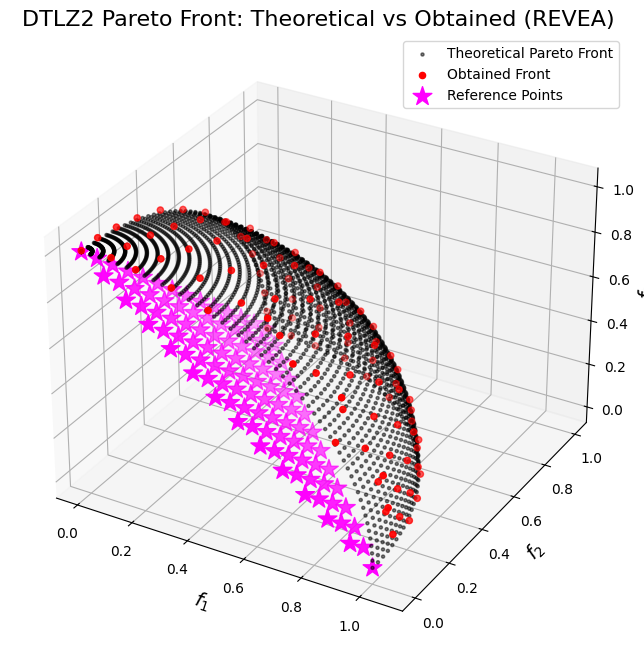

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from pymoors import (
    Revea,
    DanAndDenisReferencePoints,
    RandomSamplingFloat,
    GaussianMutation,
    SimulatedBinaryCrossover,
    CloseDuplicatesCleaner,
)
from pymoors.schemas import Population
from pymoors.typing import TwoDArray

np.seterr(invalid="ignore")


def evaluate_dtlz2(x: TwoDArray) -> TwoDArray:
    """
    Evaluate the DTLZ2 objectives for a 3-objective problem.

    The decision vector x has num_vars components. For the Pareto front,
    the auxiliary function g(x) is minimized (g(x)=0) by setting the last
    num_vars-2 variables to 0.5.

    The objectives are computed as:
      f1(x) = (1+g) * cos((pi/2)*x1) * cos((pi/2)*x2)
      f2(x) = (1+g) * cos((pi/2)*x1) * sin((pi/2)*x2)
      f3(x) = (1+g) * sin((pi/2)*x1)
    """
    # Compute the auxiliary function g(x) using variables 3 to num_vars.
    g = np.sum((x[:, 2:] - 0.5) ** 2, axis=1)
    f1 = (1 + g) * np.cos((np.pi / 2) * x[:, 0]) * np.cos((np.pi / 2) * x[:, 1])
    f2 = (1 + g) * np.cos((np.pi / 2) * x[:, 0]) * np.sin((np.pi / 2) * x[:, 1])
    f3 = (1 + g) * np.sin((np.pi / 2) * x[:, 0])
    return np.column_stack((f1, f2, f3))


def dtlz2_theoretical_front(num_points=50):
    """
    Compute a set of points approximating the theoretical Pareto front for DTLZ2 (3 objectives).

    For the Pareto-optimal front, g(x) = 0, which implies that the decision variables
    x_3, ..., x_n are fixed at 0.5. Therefore, the front can be generated by varying x1 and x2:
      f1 = cos((pi/2)*x1) * cos((pi/2)*x2)
      f2 = cos((pi/2)*x1) * sin((pi/2)*x2)
      f3 = sin((pi/2)*x1)
    These points lie on a portion of the unit hypersphere in the positive orthant.
    """
    x1 = np.linspace(0, 1, num_points)
    x2 = np.linspace(0, 1, num_points)
    X1, X2 = np.meshgrid(x1, x2)
    X1_flat = X1.flatten()
    X2_flat = X2.flatten()

    f1 = np.cos((np.pi / 2) * X1_flat) * np.cos((np.pi / 2) * X2_flat)
    f2 = np.cos((np.pi / 2) * X1_flat) * np.sin((np.pi / 2) * X2_flat)
    f3 = np.sin((np.pi / 2) * X1_flat)
    return f1, f2, f3


# Create the reference points using DanAndDenisReferencePoints.
# This object generates reference points for NSGA-III.
ref_points = DanAndDenisReferencePoints(n_reference_points=101, n_objectives=3)

# Set up the REVEA algorithm for DTLZ2.
# For DTLZ2, a typical choice is num_vars = (number of objectives - 1) + k.
# Here, we choose k = 10, so num_vars = 2 + 10 = 12.
algorithm = Revea(
    sampler=RandomSamplingFloat(min=0, max=1),
    crossover=SimulatedBinaryCrossover(distribution_index=10),
    mutation=GaussianMutation(gene_mutation_rate=0.1, sigma=0.01),
    fitness=evaluate_dtlz2,
    num_objectives=3,
    num_constraints=0,
    duplicates_cleaner=CloseDuplicatesCleaner(epsilon=1e-8),
    num_vars=12,
    population_size=100,
    num_offsprings=100,
    num_iterations=250,
    mutation_rate=0.1,
    crossover_rate=0.9,
    keep_infeasible=False,
    upper_bound=1,
    lower_bound=0,
    reference_points=ref_points.generate()[:100],
    verbose=False,
    alpha=2.0,
    seed=1729,
)

# Run the algorithm
algorithm.run()

# Get the best Pareto front obtained (as a Population instance)
best: Population = algorithm.population.best_as_population
obtained_fitness = best.fitness  # Shape: (num_solutions, 3)

# Compute the theoretical Pareto front for DTLZ2
f1_theo, f2_theo, f3_theo = dtlz2_theoretical_front(num_points=50)

# Plot the theoretical Pareto front, the obtained front, and the reference points in 3D.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the theoretical Pareto front as a scatter of many points.
ax.scatter(
    f1_theo,
    f2_theo,
    f3_theo,
    c="k",
    marker=".",
    label="Theoretical Pareto Front",
    alpha=0.5,
)

# Plot the obtained Pareto front from the algorithm.
ax.scatter(
    obtained_fitness[:, 0],
    obtained_fitness[:, 1],
    obtained_fitness[:, 2],
    c="r",
    marker="o",
    label="Obtained Front",
)

# Plot the reference points.
# Extract the reference points array from the DanAndDenisReferencePoints object.
ref_points_array = ref_points.generate()
ax.scatter(
    ref_points_array[:, 0],
    ref_points_array[:, 1],
    ref_points_array[:, 2],
    marker="*",
    s=200,
    color="magenta",
    label="Reference Points",
)

ax.set_xlabel("$f_1$", fontsize=14)
ax.set_ylabel("$f_2$", fontsize=14)
ax.set_zlabel("$f_3$", fontsize=14)
ax.set_title("DTLZ2 Pareto Front: Theoretical vs Obtained (REVEA)", fontsize=16)
ax.legend()
plt.show()